1. INSTALL / IMPORT LIBRARIES

In [1]:
!pip install pingouin -q   # for partial correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, ttest_ind, f_oneway
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.8 MB/s eta 0:00:00
✅ Libraries loaded successfully


 2. LOAD DATASET

In [2]:
FILE_NAME = 'screen_alertness_data.csv'

df = pd.read_csv(FILE_NAME)
print(f"✅ Dataset loaded: {df.shape[0]} days, {df.shape[1]} columns")
print(f"📅 Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\n📋 First 5 rows:")
df.head()

✅ Dataset loaded: 63 days, 10 columns
📅 Date range: 2024-11-30 to 2025-01-31

📋 First 5 rows:


,Date,Bedtime,Waketime,Last Screen,Screen Total,Social Media,Entertainment,Productivity,Alertness,Weekend
0,2024-11-30,12:30 am,9:00 am,12:15 am,345,145,168,18,2,1
1,2024-12-01,11:45 pm,8:30 am,11:30 pm,267,98,124,32,4,1
2,2024-12-02,11:30 pm,6:45 am,11:15 pm,245,78,98,52,4,0
3,2024-12-03,11:45 pm,7:00 am,11:30 pm,256,89,102,48,4,0
4,2024-12-04,12:00 am,7:15 am,11:45 pm,278,94,115,45,3,0


3. DATA CLEANING & FEATURE ENGINEERING

In [3]:
# ----- Convert time columns to datetime and extract decimal hours -----
def time_to_hour(time_str):
    """Convert '12:30 am', '11:45 pm' etc. to decimal hour (0-24)."""
    try:
        dt = pd.to_datetime(time_str, format='%I:%M %p')
        return dt.hour + dt.minute / 60.0
    except:
        return np.nan

In [4]:
# Apply conversion
df['bedtime_hour'] = df['Bedtime'].apply(time_to_hour)
df['waketime_hour'] = df['Waketime'].apply(time_to_hour)
df['last_screen_hour'] = df['Last Screen'].apply(time_to_hour)

In [5]:
# ----- Compute sleep duration (handling overnight) -----
df['sleep_hours'] = np.where(
    df['waketime_hour'] >= df['bedtime_hour'],
    df['waketime_hour'] - df['bedtime_hour'],
    (df['waketime_hour'] + 24) - df['bedtime_hour']
)

In [6]:
# ----- Cap unrealistic sleep hours (e.g., >12h or <3h) -----
df['sleep_hours'] = df['sleep_hours'].clip(3, 12)

In [7]:
# Adjust times after midnight (e.g., 12:30 am = 0.5 → 24.5)
df['last_screen_hour_adj'] = df['last_screen_hour'].apply(lambda x: x if x >= 12 else x + 24)

# ----- Create binary variable: Late screen (based on median of ADJUSTED hour) -----
median_last_screen_adj = df['last_screen_hour_adj'].median()
df['late_screen_adj'] = (df['last_screen_hour_adj'] > median_last_screen_adj).astype(int)

In [8]:
# ----- Create categorical variable for total screen time (low/med/high) -----
# Use tertiles for three groups
df['screen_total_cat'] = pd.qcut(
    df['Screen Total'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

In [9]:
# ----- Create binary good alertness (for optional logistic regression) -----
df['good_alertness'] = (df['Alertness'] >= 4).astype(int)

print("\n✅ Feature engineering complete")
print(f"   Median last screen hour: {median_last_screen_adj:.2f}")
print(f"   Sleep hours range: {df['sleep_hours'].min():.1f}–{df['sleep_hours'].max():.1f}")
print(f"   Screen time categories: {df['screen_total_cat'].unique()}")


✅ Feature engineering complete
   Median last screen hour: 23.50
   Sleep hours range: 7.0–9.0
   Screen time categories: ['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']


4. DESCRIPTIVE STATISTICS (Quick overview)

In [10]:
print("\n" + "="*70)
print("📊 DESCRIPTIVE STATISTICS")
print("="*70)
desc_vars = ['sleep_hours', 'last_screen_hour', 'Screen Total',
             'Social Media', 'Entertainment', 'Productivity', 'Alertness']
print(df[desc_vars].describe().round(2))


📊 DESCRIPTIVE STATISTICS
       sleep_hours  last_screen_hour  Screen Total  Social Media  \
count        63.00             63.00         63.00         63.00   
mean          7.68             15.83        285.27        106.89   
std           0.63             10.84         50.57         39.89   
min           7.00              0.25        223.00         65.00   
25%           7.25              0.75        256.00         78.00   
50%           7.25             23.25        267.00         89.00   
75%           8.00             23.50        312.00        134.00   
max           9.00             23.75        456.00        234.00   

       Entertainment  Productivity  Alertness  
count          63.00         63.00      63.00  
mean          118.37         42.05       3.06  
std            30.72         17.08       1.03  
min            76.00         12.00       1.00  
25%            98.00         24.00       2.00  
50%           112.00         48.00       3.00  
75%           142.00     

TEST 1: PEARSON CORRELATION

In [11]:
print("\n" + "="*70)
print("📈 TEST 1: PEARSON CORRELATION")
print("="*70)

# 5.1 Last screen time vs Alertness
r1, p1 = pearsonr(df['last_screen_hour_adj'], df['Alertness'])
print("\n🔹 Last Screen Hour  vs  Morning Alertness")
print(f"   r = {r1:.3f}, p = {p1:.4f}")
if p1 < 0.05:
    print(f"   ✅ Statistically significant (p < 0.05)")
else:
    print(f"   ❌ Not significant (p >= 0.05)")
print(f"   Interpretation: {'Negative' if r1<0 else 'Positive'} correlation, "
      f"{'strong' if abs(r1)>0.5 else 'moderate' if abs(r1)>0.3 else 'weak'} strength")

# 5.2 Sleep hours vs Alertness
r2, p2 = pearsonr(df['sleep_hours'], df['Alertness'])
print("\n🔹 Sleep Hours  vs  Morning Alertness")
print(f"   r = {r2:.3f}, p = {p2:.4f}")
print(f"   {'✅ Significant' if p2<0.05 else '❌ Not significant'}")

# 5.3 Total screen time vs Alertness
r3, p3 = pearsonr(df['Screen Total'], df['Alertness'])
print("\n🔹 Total Screen Time (min)  vs  Morning Alertness")
print(f"   r = {r3:.3f}, p = {p3:.4f}")
print(f"   {'✅ Significant' if p3<0.05 else '❌ Not significant'}")

# 5.4 Social media vs Alertness
r4, p4 = pearsonr(df['Social Media'], df['Alertness'])
print("\n🔹 Social Media Time (min)  vs  Morning Alertness")
print(f"   r = {r4:.3f}, p = {p4:.4f}")
print(f"   {'✅ Significant' if p4<0.05 else '❌ Not significant'}")


📈 TEST 1: PEARSON CORRELATION

🔹 Last Screen Hour  vs  Morning Alertness
   r = -0.939, p = 0.0000
   ✅ Statistically significant (p < 0.05)
   Interpretation: Negative correlation, strong strength

🔹 Sleep Hours  vs  Morning Alertness
   r = -0.234, p = 0.0645
   ❌ Not significant

🔹 Total Screen Time (min)  vs  Morning Alertness
   r = -0.929, p = 0.0000
   ✅ Significant

🔹 Social Media Time (min)  vs  Morning Alertness
   r = -0.927, p = 0.0000
   ✅ Significant


 TEST 2: INDEPENDENT T-TEST

In [12]:
print("\n" + "="*70)
print("📊 TEST 2: INDEPENDENT T-TEST")
print("="*70)

# 6.1 Early screen vs Late screen (based on median)
early_alert = df[df['late_screen_adj'] == 0]['Alertness']
late_alert  = df[df['late_screen_adj'] == 1]['Alertness']

t_stat, p_ttest = ttest_ind(early_alert, late_alert, equal_var=False)
print(f"Early screen mean alertness: {early_alert.mean():.2f}")
print(f"Late screen mean alertness: {late_alert.mean():.2f}")
print(f"   Early screen mean alertness: {early_alert.mean():.2f} (n={len(early_alert)})")
print(f"   Late screen  mean alertness: {late_alert.mean():.2f} (n={len(late_alert)})")
print(f"   Difference: {early_alert.mean() - late_alert.mean():.2f}")
print(f"   t = {t_stat:.3f}, p = {p_ttest:.4f}")
print(f"   {'✅ Significant difference' if p_ttest<0.05 else '❌ No significant difference'}")

# 6.2 Weekday vs Weekend
weekday_alert = df[df['Weekend'] == 0]['Alertness']
weekend_alert = df[df['Weekend'] == 1]['Alertness']
t_stat2, p_ttest2 = ttest_ind(weekday_alert, weekend_alert, equal_var=False)

print("\n🔹 Weekday  vs  Weekend Alertness")
print(f"   Weekday mean alertness: {weekday_alert.mean():.2f} (n={len(weekday_alert)})")
print(f"   Weekend mean alertness: {weekend_alert.mean():.2f} (n={len(weekend_alert)})")
print(f"   Difference: {weekday_alert.mean() - weekend_alert.mean():.2f}")
print(f"   t = {t_stat2:.3f}, p = {p_ttest2:.4f}")
print(f"   {'✅ Significant difference' if p_ttest2<0.05 else '❌ No significant difference'}")


📊 TEST 2: INDEPENDENT T-TEST
Early screen mean alertness: 3.86
Late screen mean alertness: 2.07
   Early screen mean alertness: 3.86 (n=35)
   Late screen  mean alertness: 2.07 (n=28)
   Difference: 1.79
   t = 12.859, p = 0.0000
   ✅ Significant difference

🔹 Weekday  vs  Weekend Alertness
   Weekday mean alertness: 3.46 (n=35)
   Weekend mean alertness: 2.57 (n=28)
   Difference: 0.89
   t = 3.620, p = 0.0007
   ✅ Significant difference


TEST 3: PARTIAL CORRELATION

In [13]:
print("\n" + "="*70)
print("🔬 TEST 3: PARTIAL CORRELATION")
print("="*70)
print("   Isolates the effect of last screen time on alertness")
print("   while controlling for sleep duration.\n")

# Partial correlation: last_screen_hour vs Alertness, controlling for sleep_hours
partial = pg.partial_corr(
    data=df,
    x='last_screen_hour_adj',
    y='Alertness',
    covar='sleep_hours',
    method='pearson'
)

r_partial = partial['r'].values[0]
p_partial = partial['p-val'].values[0]
df_partial = partial['n'].values[0] - 2 # Corrected: Degrees of freedom for partial correlation

print(f"   Partial correlation r (controlling for sleep) = {r_partial:.3f}")
print(f"   p-value = {p_partial:.4f}")
print(f"   degrees of freedom = {df_partial}")

# Compare with simple correlation
print(f"\n   📌 Simple correlation (without control): r = {r1:.3f}, p = {p1:.4f}")
print(f"   📌 Partial correlation (controlling sleep): r = {r_partial:.3f}, p = {p_partial:.4f}")
print(f"   Change: {r_partial - r1:+.3f}")

if p_partial < 0.05:
    print("\n   ✅ EVEN AFTER controlling for sleep duration,")
    print("      last screen time significantly predicts morning alertness.")
    print("      → This suggests an INDEPENDENT effect of evening screen use.")
else:
    print("\n   ❌ After controlling for sleep duration, the relationship")
    print("      is NOT significant. The effect may be explained by sleep loss.")


🔬 TEST 3: PARTIAL CORRELATION
   Isolates the effect of last screen time on alertness
   while controlling for sleep duration.

   Partial correlation r (controlling for sleep) = -0.937
   p-value = 0.0000
   degrees of freedom = 61

   📌 Simple correlation (without control): r = -0.939, p = 0.0000
   📌 Partial correlation (controlling sleep): r = -0.937, p = 0.0000
   Change: +0.002

   ✅ EVEN AFTER controlling for sleep duration,
      last screen time significantly predicts morning alertness.
      → This suggests an INDEPENDENT effect of evening screen use.


 TEST 4: ONE-WAY ANOVA

In [14]:
print("\n" + "="*70)
print("📊 TEST 4: ONE-WAY ANOVA")
print("="*70)
print("   Comparing morning alertness across low/medium/high total screen time")

# Group alertness by screen total category
group_low  = df[df['screen_total_cat'] == 'Low']['Alertness']
group_med  = df[df['screen_total_cat'] == 'Medium']['Alertness']
group_high = df[df['screen_total_cat'] == 'High']['Alertness']

# Perform ANOVA
f_stat, p_anova = f_oneway(group_low, group_med, group_high)

print(f"\n   Low screen mean alertness:  {group_low.mean():.2f} (n={len(group_low)})")
print(f"   Medium screen mean alertness: {group_med.mean():.2f} (n={len(group_med)})")
print(f"   High screen mean alertness: {group_high.mean():.2f} (n={len(group_high)})")
print(f"\n   F-statistic = {f_stat:.3f}, p = {p_anova:.4f}")

if p_anova < 0.05:
    print("   ✅ Significant difference among at least one group.")
    # Post-hoc: pairwise t-tests with Bonferroni correction
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests

    pairs = [
        ('Low', 'Medium', group_low, group_med),
        ('Low', 'High', group_low, group_high),
        ('Medium', 'High', group_med, group_high)
    ]
    p_vals = []
    for name1, name2, g1, g2 in pairs:
        _, p = ttest_ind(g1, g2, equal_var=False)
        p_vals.append(p)

    reject, p_corr, _, _ = multipletests(p_vals, alpha=0.05, method='bonferroni')
    print("\n   Post-hoc pairwise comparisons (Bonferroni corrected):")
    for i, (name1, name2, _, _) in enumerate(pairs):
        print(f"      {name1} vs {name2}: p = {p_vals[i]:.4f} "
              f"(corrected p = {p_corr[i]:.4f}) - {'Significant' if reject[i] else 'Not significant'}")
else:
    print("   ❌ No significant difference between screen time groups.")


📊 TEST 4: ONE-WAY ANOVA
   Comparing morning alertness across low/medium/high total screen time

   Low screen mean alertness:  4.00 (n=28)
   Medium screen mean alertness: 3.14 (n=14)
   High screen mean alertness: 1.76 (n=21)

   F-statistic = 327.069, p = 0.0000
   ✅ Significant difference among at least one group.

   Post-hoc pairwise comparisons (Bonferroni corrected):
      Low vs Medium: p = 0.0000 (corrected p = 0.0000) - Significant
      Low vs High: p = 0.0000 (corrected p = 0.0000) - Significant
      Medium vs High: p = 0.0000 (corrected p = 0.0000) - Significant



🎨 GENERATING VISUALIZATIONS


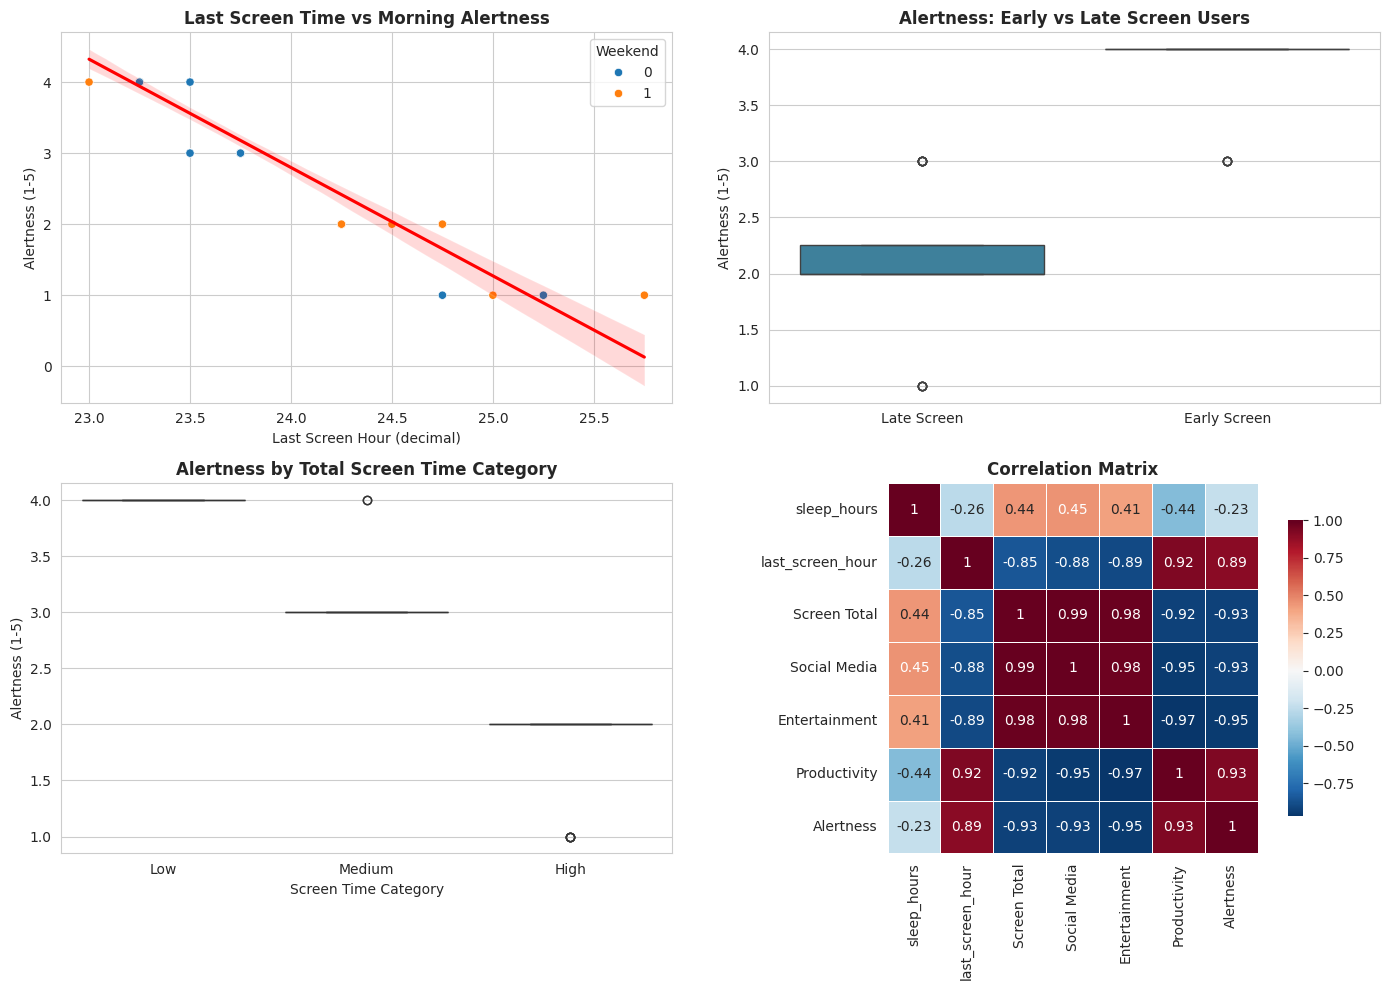

✅ Visualizations saved as 'screen_alertness_analysis.png'


In [15]:
print("\n" + "="*70)
print("🎨 GENERATING VISUALIZATIONS")
print("="*70)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter: Last screen hour vs Alertness
ax = axes[0,0]
sns.scatterplot(data=df, x='last_screen_hour_adj', y='Alertness', hue='Weekend', ax=ax)
sns.regplot(data=df, x='last_screen_hour_adj', y='Alertness', scatter=False, ax=ax, color='red')
ax.set_title('Last Screen Time vs Morning Alertness', fontweight='bold')
ax.set_xlabel('Last Screen Hour (decimal)')
ax.set_ylabel('Alertness (1-5)')

# 2. Boxplot: Early vs Late screen alertness
ax = axes[0,1]
df_box = df.copy()
df_box['screen_group'] = df_box['late_screen_adj'].map({0:'Early Screen', 1:'Late Screen'}) # Changed 'late_screen' to 'late_screen_adj'
sns.boxplot(data=df_box, x='screen_group', y='Alertness', palette=['#2E86AB','#A23B72'], ax=ax)
ax.set_title('Alertness: Early vs Late Screen Users', fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Alertness (1-5)')

# 3. Boxplot: Screen time categories vs Alertness
ax = axes[1,0]
sns.boxplot(data=df, x='screen_total_cat', y='Alertness',
            order=['Low','Medium','High'], palette='viridis', ax=ax)
ax.set_title('Alertness by Total Screen Time Category', fontweight='bold')
ax.set_xlabel('Screen Time Category')
ax.set_ylabel('Alertness (1-5)')

# 4. Correlation heatmap
ax = axes[1,1]
corr_vars = ['sleep_hours', 'last_screen_hour', 'Screen Total',
             'Social Media', 'Entertainment', 'Productivity', 'Alertness']
corr_matrix = df[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink':0.8}, ax=ax)
ax.set_title('Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.savefig('screen_alertness_analysis.png', dpi=150)
plt.show()
print("✅ Visualizations saved as 'screen_alertness_analysis.png'")

 10. SUMMARY OF FINDINGS

In [16]:
print("\n" + "="*70)
print("📋 SUMMARY OF FINDINGS")
print("="*70)
print(f"""
🔷 PEARSON CORRELATION:
   • Last screen hour & alertness: r = {r1:.3f}, p = {p1:.4f}
   • Sleep hours & alertness:      r = {r2:.3f}, p = {p2:.4f}
   • Total screen & alertness:     r = {r3:.3f}, p = {p3:.4f}
   • Social media & alertness:     r = {r4:.3f}, p = {p4:.4f}

🔷 INDEPENDENT T-TEST:
   • Early screen alertness: {early_alert.mean():.2f}
   • Late screen alertness:  {late_alert.mean():.2f}
   • Difference: {early_alert.mean()-late_alert.mean():.2f}, p = {p_ttest:.4f}

🔷 PARTIAL CORRELATION (KEY FINDING):
   • Controlling for sleep duration: r = {r_partial:.3f}, p = {p_partial:.4f}
   → {'Independent effect exists' if p_partial<0.05 else 'No independent effect'}

🔷 ONE-WAY ANOVA:
   • Screen time categories & alertness: F = {f_stat:.3f}, p = {p_anova:.4f}
""")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE")
print("="*70)


📋 SUMMARY OF FINDINGS

🔷 PEARSON CORRELATION:
   • Last screen hour & alertness: r = -0.939, p = 0.0000
   • Sleep hours & alertness:      r = -0.234, p = 0.0645
   • Total screen & alertness:     r = -0.929, p = 0.0000
   • Social media & alertness:     r = -0.927, p = 0.0000

🔷 INDEPENDENT T-TEST:
   • Early screen alertness: 3.86
   • Late screen alertness:  2.07
   • Difference: 1.79, p = 0.0000

🔷 PARTIAL CORRELATION (KEY FINDING):
   • Controlling for sleep duration: r = -0.937, p = 0.0000
   → Independent effect exists

🔷 ONE-WAY ANOVA:
   • Screen time categories & alertness: F = 327.069, p = 0.0000


✅ ANALYSIS COMPLETE
